<a href="https://colab.research.google.com/github/yosuke7040/atmacup8/blob/main/%E8%AC%9B%E5%BA%A7_1_%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E7%9C%BA%E3%82%81%E3%81%A6_submission_%E3%82%92%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pandas-profiling/pandas-profiling.git

In [ ]:
!pip show pandas_profiling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
##from pandas_profiling.utils.cache import cache_file
from matplotlib_venn import venn2 # venn図を作成する用
%matplotlib inline

sns.set_style('ticks')

In [18]:
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/atmacup08/data/inputs/'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/atmacup08/data/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
whole_df.T

#**train/testのReportをさっくり作る**

pandas profiling というライブラリがあり、こちらを使うとデータフレームの統計量を一気に確認することが可能です。簡単な使い方は ProfileReport class に可視化したいデータフレームを渡して repot を作り to_file を呼び出して html ファイルとして保存する方法です。

保存した html をブラウザなどで開くと以下のような統計量をカラムごとに確認できてとても便利です。

ユニークな値の数
頻度の高い値
意味の無いカラムや Null が多いカラムかどうか …etc

In [ ]:
report = ProfileReport(train_df)
report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

In [ ]:
c = 'Year_of_Release'

fig, ax = plt.subplots(figsize=(5,3))
# venn2は２つの円、venn3は３つ使える
venn2(
    subsets = ( set( train_df[c].unique() ), set( test_df[c].unique() ) ),
    set_labels = ('Train', 'Test'),
    ax = ax
)
ax.set_title(c)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
venn2(
    # これで集合を作図してくれるのかと思ったら、この数値をそのまま使う
    # 引数は先頭から3つしか受け付けない？
    # 集合で渡してやれば、和集合や積集合計算しそう
    subsets = ( 11,13,17 ),
)


In [ ]:
columns = test_df.columns
n_figs  = len( columns )
n_cols = 4
n_rows = n_figs // n_cols + 1 # 整数除算

fig, axes = plt.subplots(
    figsize = (n_cols * 3, n_rows * 3),
    ncols = n_cols,
    nrows = n_rows)

# ravelは多次元リストを１次元のリストへ
for c, ax in zip( columns, axes.ravel() ):
    venn2(
        subsets = ( set(train_df[c].unique()), set(test_df[c].unique()) ),
        set_labels = ( 'Train', 'Test' ),
        ax = ax
    )
    ax.set_title(c)

fig.tight_layout()

In [ ]:
train_df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

# 欠損値の処理

In [19]:
# アノテーション
# 引数( : )がpd.DataFrame, 返り値(->)もDataFrameを示してる。チェックされないのでコメント的なニュアンス
def preprocess( input_df: pd.DataFrame ) -> pd.DataFrame:
    output_df = input_df.copy()
    # tbdはまだやってない
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features( input_df ):
    # ここでtrain_df['--']みたいにグローバル使うと込み入ったときに大変になるから内部だけで完結するようにする
    input_df = preprocess( input_df )
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count',
        'User_Score',
        'User_Count',
        'Year_of_Release'
    ]
    return input_df[ use_columns ].copy()

In [6]:
# テスト
# assert 条件式, 条件式がFalseの場合に出力するメッセージ
# 今回は条件式だけ
assert len( create_continuous_features( train_df ) )  == len( train_df )

In [7]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

## Booleanの特日量

In [20]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan',
        'nintendo'
    ]
    """
    DataFrameは真偽値のTrueだけを抽出する
    str.lower():すべての文字を小文字,containの前にすることでtextsと一致させる
    str.contains(x):xを含むとTrueとなるpandas.Seriesを返す
    nanがあると抽出でnanを返すからfillnaで先に埋める
    contains()まででboolだから最後int(0,1)に変換
    """
    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [9]:
#train_df['Developer'].fillna('').head(20).str.lower().str.contains('tales').astype(int)

In [10]:
create_boolean_feature(train_df).sum()

Developer_has_japan       23
Developer_has_nintendo    88
dtype: int64

In [21]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [22]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_boolean_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [23]:
train_feat_df = to_feature( train_df )
test_feat_df = to_feature( test_df )

100%|██████████| 2/2 [00:00<00:00, 82.77it/s]

create create_continuous_features 0.010[s]
create create_boolean_feature 0.016[s]
create create_continuous_features 0.007[s]
create create_boolean_feature 0.015[s]


### LightGBM による CrossValidation を用いた学習

In [25]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error

def fit_lgbm( X,
              y,
              cv,
              params: dict = None,
              verbose: int = 10 ):
    """ lightGBM を CrossValidation の枠組みで学習を行う function """

    # パラメータがないときは、空のdictで置き換える
    if params is None:
        params ={}

    models = []
    """ 
    training data の target と同じだけのゼロ配列を用意
    float にしないと悲しい事件が起こるのでそこだけ注意
    """
    oof_pred = np.zeros_like( y, dtype = np.float )
    
    for i, ( idx_train, idx_valid ) in enumerate( cv ):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # **付き引数は辞書型,メソッド内で値は変更できるが大本は変更なし
        # **なしで渡すと元も変更されてしまう
        clf = lgbm.LGBMRegressor( **params )

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        # global salesは０以下になるわけがないので, 0以下は0に丸め込み
        # whereはcの３項演算子でみたらおｋ
        pred_i = np.where(pred_i < 0, 0, pred_i)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        # a ** b は aの b乗 .5は0.5で整数部が0は省略可
        # RMSLE = numpy.sqrt(sklearn.metrics.mean_squared_log_error()) or {mean_squared_log_error(y_valid, pred_i) ** .5
        print(f'Fold {i} RMSLE: {mean_squared_log_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_log_error(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [15]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values

In [16]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [26]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 154.85
[20]	valid_0's rmse: 152.841
[30]	valid_0's rmse: 151.486
[40]	valid_0's rmse: 153.219
Early stopping, best iteration is:
[30]	valid_0's rmse: 151.486
fit fold=1 0.040[s]
Fold 0 RMSLE: 1.5242
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 240.156
[20]	valid_0's rmse: 234.979
[30]	valid_0's rmse: 234.198
[40]	valid_0's rmse: 233.793
Early stopping, best iteration is:
[37]	valid_0's rmse: 233.526
fit fold=2 0.037[s]
Fold 1 RMSLE: 1.4675
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 146.814
[20]	valid_0's rmse: 146.388
Early stopping, best iteration is:
[16]	valid_0's rmse: 145.77
fit fold=3 0.023[s]
Fold 2 RMSLE: 1.5313
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 145.936
[20]	valid_0's rmse: 140.966
[30]	valid_0's rmse: 140.182
[40]	valid_0's rmse: 139.359
[50]	valid_0's rmse: 139.978
Earl

In [ ]:
models

In [32]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

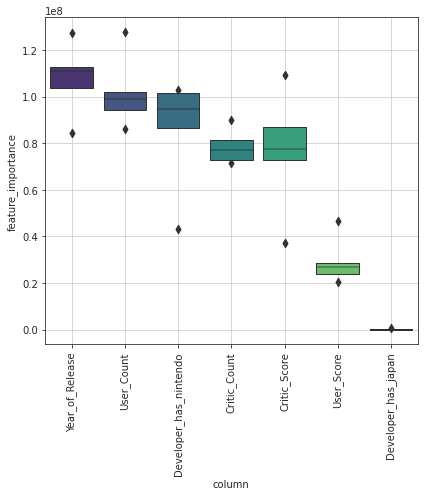

In [41]:
fig, ax = visualize_importance(models, train_feat_df)

In [36]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'simple_submission.csv'), index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


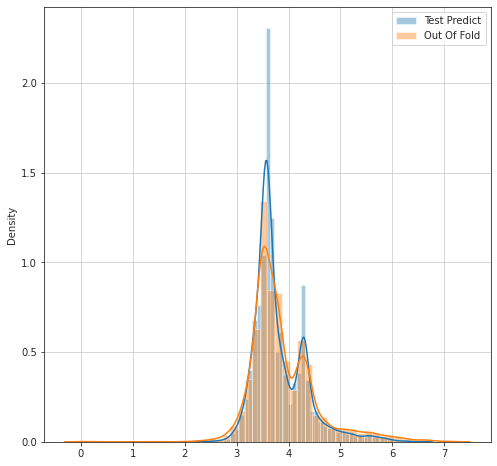

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(np.log1p(oof), label='Out Of Fold')
ax.legend()
ax.grid()